In [445]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [446]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22050 entries, 0 to 22049
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22050 non-null  object 
 1   description               22050 non-null  object 
 2   summary                   22049 non-null  object 
 3   installs                  22050 non-null  object 
 4   minInstalls               22050 non-null  float64
 5   score                     22050 non-null  float64
 6   ratings                   22050 non-null  float64
 7   reviews                   22050 non-null  float64
 8   histogram                 22050 non-null  object 
 9   price                     22050 non-null  float64
 10  free                      22050 non-null  int64  
 11  currency                  22050 non-null  object 
 12  sale                      22050 non-null  bool   
 13  offersIAP                 22050 non-null  bool   
 14  inAppP

In [447]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [448]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [449]:
df = df[df['updated_year'] > 2013]

In [450]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [451]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

In [452]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

In [453]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [454]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [455]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

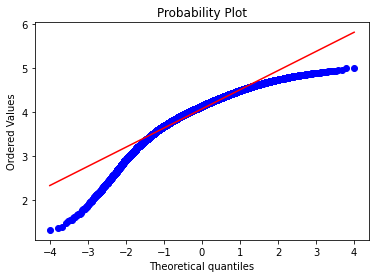

In [456]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 21923
- Mean of distribution of rating : 4.068430197755752
- Standard deviation: 0.45003169354660655


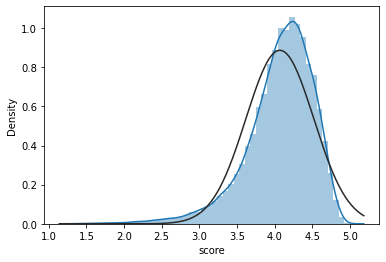

In [457]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

## No pipeline

In [458]:
features = ['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Events', 'genre_Finance', 'genre_Food & Drink',
       'genre_Health & Fitness', 'genre_House & Home',
       'genre_Libraries & Demo', 'genre_Lifestyle', 'genre_Maps & Navigation',
       'genre_Medical', 'genre_Music', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_Tools', 'genre_Travel & Local', 'genre_Trivia',
       'genre_Video Players & Editors', 'genre_Weather', 'genre_Word',
       'contentRating_Everyone 10+', 'contentRating_Mature 17+',
       'contentRating_Teen']

In [459]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.40
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [460]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.14
containsAds : 0.01
editorsChoice : 0.08
year : -0.01
top_developer : 0.39
installs_day : 0.00
updated_days : -0.00
has_video : 0.05
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.00
genre_Art & Design : -0.08
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.07
genre_Board : 0.10
genre_Books & Reference : 0.12
genre_Business : 0.08
genre_Card : 0.16
genre_Casino : 0.19
genre_Casual : -0.04
genre_Comics : -0.05
genre_Communication : 0.05
genre_Dating : -0.07
genre_Education : 0.03
genre_Entertainment : -0.05
genre_Events : -0.41
genre_Finance : 0.11
genre_Food & Drink : 0.09
genre_Health & Fitness : 0.09
genre_House & Home : 0.04
genre_Libraries & Demo : 0.13
genre_Lifestyle : -0.01
genre_Maps & Navigation : 0.10
genre_Medical : -0.01
genre_Music : -0.04
genre_Music & Audio : 0.07
genre_News & Magazines : 0.01
genre_Parenting : 0.05
genre_Personalization : 0.09
genre_Photography : -0.05
genre_Productivity : 0.09
genre_Puzz

In [461]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [462]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [463]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.819115,2.143439
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.276627,2.124453
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.813125,1.834792
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.785543,1.707858
1434,60013.0,1,1,0,2013,0,360.750361,2385,1,-0.028224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.044781,3.684349,1.639568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5827,19355.0,1,1,0,2016,0,593.119810,67,1,0.098122,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.612256,3.794812,-0.817444
9189,6026.0,1,0,0,2020,0,5376.344086,33,0,-0.074129,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.465190,3.645439,-0.819751
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.628247,-0.908546
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.688473,-0.921372


In [464]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [465]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,17673.005000,0.998333,0.801667,0.003333,2016.090000,0.023333,969.840440,356.573333,0.290000,0.239434,...,0.006667,0.018333,0.006667,0.008333,0.036667,0.045000,0.143333,3.461525,4.012702,0.551177
std,37010.072396,0.040825,0.399077,0.057687,2.631877,0.151086,911.289842,441.216021,0.454141,0.248530,...,0.081445,0.134266,0.081445,0.090982,0.188099,0.207477,0.350705,0.484976,0.342756,0.288965
min,1065.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,247.035573,0.000000,0.000000,-0.340074,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.675676,3.157437,0.266047
25%,3799.500000,1.000000,1.000000,0.000000,2014.000000,0.000000,429.692068,54.000000,0.000000,0.050897,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.194473,3.777133,0.345553
50%,7250.000000,1.000000,1.000000,0.000000,2016.000000,0.000000,654.879128,174.000000,0.000000,0.203246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.490026,3.945898,0.459762
75%,14721.750000,1.000000,1.000000,0.000000,2018.000000,0.000000,1157.742693,492.250000,1.000000,0.395066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.773197,4.224327,0.676282
max,364749.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,6369.426752,2531.000000,1.000000,0.882937,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.854529,5.656929,2.143439


In [466]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,...,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000,885.000000
mean,21364.800000,0.998870,0.855367,0.007910,2016.136723,0.092655,913.136470,353.254237,0.383051,0.293469,...,0.006780,0.009040,0.009040,0.005650,0.041808,0.031638,0.149153,4.124362,4.122639,-0.001723
std,29077.661903,0.033615,0.351929,0.088634,2.410961,0.290113,790.229008,441.722856,0.486405,0.164673,...,0.082106,0.094699,0.094699,0.074994,0.200263,0.175134,0.356440,0.289083,0.287181,0.056412
min,1010.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,249.937516,0.000000,0.000000,-0.318454,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.351916,3.366734,-0.099917
25%,5309.000000,1.000000,1.000000,0.000000,2014.000000,0.000000,436.300175,48.000000,0.000000,0.188474,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.923780,3.933385,-0.049400
50%,11206.000000,1.000000,1.000000,0.000000,2017.000000,0.000000,657.894737,190.000000,0.000000,0.291827,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.087566,4.085863,-0.003729
75%,24438.000000,1.000000,1.000000,0.000000,2018.000000,0.000000,1004.016064,477.000000,1.000000,0.403809,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.289100,4.275533,0.043478
max,292282.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,6289.308176,2431.000000,1.000000,0.841917,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.926471,4.933284,0.099568


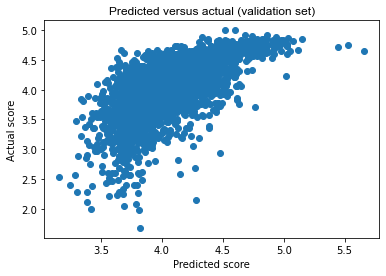

In [467]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

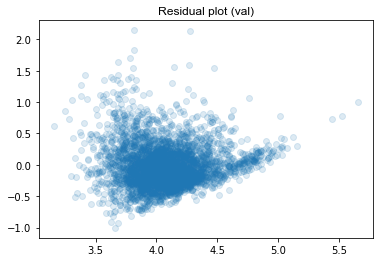

In [468]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Removing ratings

The sections below iteratively remove features which the model is not using (0.0) or which have very low coefficients. This is to manage for overfitting

In [469]:
features2 = features.copy()
features2.remove('ratings')

In [470]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred2))))

R^2 of linear regression on val set: 0.36
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [471]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.07
containsAds : -0.01
editorsChoice : 0.15
year : -0.01
top_developer : 0.48
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.08
genre_Beauty : -0.08
genre_Board : 0.11
genre_Books & Reference : 0.11
genre_Business : 0.07
genre_Card : 0.20
genre_Casino : 0.25
genre_Casual : -0.04
genre_Comics : -0.07
genre_Communication : 0.04
genre_Dating : -0.09
genre_Education : -0.00
genre_Entertainment : -0.06
genre_Events : -0.43
genre_Finance : 0.14
genre_Food & Drink : 0.08
genre_Health & Fitness : 0.08
genre_House & Home : 0.04
genre_Libraries & Demo : 0.17
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.08
genre_Medical : -0.02
genre_Music : -0.02
genre_Music & Audio : 0.05
genre_News & Magazines : 0.00
genre_Parenting : 0.02
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.07
genre_Puzzle : 0.12
ge

In [472]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [473]:
check2.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.950775,2.275099
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.298526,2.146352
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.753617,1.775284
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.772749,1.695063
4159,8852.0,1,0,0,2016,0,634.115409,477,0,0.453815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.685876,4.289721,1.603845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16208,43534.0,1,1,0,2016,0,574.712644,1472,0,0.091491,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.495295,3.677025,-0.818270
8219,112221.0,1,1,0,2015,0,457.247371,19,0,0.093042,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.622097,3.748513,-0.873584
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.688748,-0.921097
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.609617,-0.927175


## Removing installs / day

In [474]:
features3 = features2.copy()
features3.remove('installs_day')

In [475]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred3))))

R^2 of linear regression on val set: 0.36
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [476]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.06
containsAds : -0.01
editorsChoice : 0.16
year : -0.01
top_developer : 0.48
updated_days : -0.00
has_video : 0.07
compound : 1.14
genre_Adventure : -0.12
genre_Arcade : 0.02
genre_Art & Design : -0.10
genre_Auto & Vehicles : 0.08
genre_Beauty : -0.08
genre_Board : 0.11
genre_Books & Reference : 0.11
genre_Business : 0.07
genre_Card : 0.21
genre_Casino : 0.25
genre_Casual : -0.04
genre_Comics : -0.07
genre_Communication : 0.04
genre_Dating : -0.09
genre_Education : -0.00
genre_Entertainment : -0.06
genre_Events : -0.42
genre_Finance : 0.14
genre_Food & Drink : 0.08
genre_Health & Fitness : 0.08
genre_House & Home : 0.04
genre_Libraries & Demo : 0.17
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.08
genre_Medical : -0.01
genre_Music : -0.02
genre_Music & Audio : 0.05
genre_News & Magazines : 0.00
genre_Parenting : 0.03
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.07
genre_Puzzle : 0.12
genre_Racing : -0.01
g

In [477]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [478]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.936136,2.260461
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.306883,2.154709
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.755629,1.777296
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.766286,1.688600
4159,8852.0,1,0,0,2016,0,634.115409,477,0,0.453815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.685876,4.297119,1.611243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8219,112221.0,1,1,0,2015,0,457.247371,19,0,0.093042,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.622097,3.754839,-0.867259
16938,42532.0,1,1,0,2020,0,6802.721088,107,0,0.026419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.601597,3.711231,-0.890366
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.617993,-0.918800
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.672611,-0.937234


## Removing updated days

In [479]:
features4 = features3.copy()
features4.remove('updated_days')

In [480]:
lr4 = LinearRegression()

lr4.fit(X_train[features4], y_train)

y_pred4 = lr4.predict(X_val[features4])
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(mean_squared_error(y_val, y_pred4)))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred4))))

R^2 of linear regression on val set: 0.35
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [481]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features4].columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.07
containsAds : -0.01
editorsChoice : 0.16
year : -0.01
top_developer : 0.48
has_video : 0.08
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.07
genre_Board : 0.13
genre_Books & Reference : 0.13
genre_Business : 0.09
genre_Card : 0.22
genre_Casino : 0.26
genre_Casual : -0.03
genre_Comics : -0.06
genre_Communication : 0.06
genre_Dating : -0.06
genre_Education : 0.01
genre_Entertainment : -0.05
genre_Events : -0.40
genre_Finance : 0.17
genre_Food & Drink : 0.10
genre_Health & Fitness : 0.10
genre_House & Home : 0.05
genre_Libraries & Demo : 0.16
genre_Lifestyle : -0.01
genre_Maps & Navigation : 0.11
genre_Medical : 0.01
genre_Music : -0.02
genre_Music & Audio : 0.06
genre_News & Magazines : 0.03
genre_Parenting : 0.05
genre_Personalization : 0.07
genre_Photography : -0.06
genre_Productivity : 0.09
genre_Puzzle : 0.13
genre_Racing : -0.02
genre_Role Playing : -0.

In [482]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [483]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.936136,2.260461
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.306883,2.154709
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.755629,1.777296
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.766286,1.688600
4159,8852.0,1,0,0,2016,0,634.115409,477,0,0.453815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.685876,4.297119,1.611243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8219,112221.0,1,1,0,2015,0,457.247371,19,0,0.093042,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.622097,3.754839,-0.867259
16938,42532.0,1,1,0,2020,0,6802.721088,107,0,0.026419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.601597,3.711231,-0.890366
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.617993,-0.918800
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.672611,-0.937234


## Removing year and mature

In [484]:
features5 = features4.copy()
features5.remove('year')
features5.remove('contentRating_Mature 17+')

In [485]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred5))))

R^2 of linear regression on val set: 0.35
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [486]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.08
containsAds : -0.01
editorsChoice : 0.16
top_developer : 0.48
has_video : 0.08
compound : 1.14
genre_Adventure : -0.12
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.07
genre_Board : 0.13
genre_Books & Reference : 0.14
genre_Business : 0.10
genre_Card : 0.23
genre_Casino : 0.27
genre_Casual : -0.03
genre_Comics : -0.06
genre_Communication : 0.06
genre_Dating : -0.06
genre_Education : 0.02
genre_Entertainment : -0.05
genre_Events : -0.41
genre_Finance : 0.17
genre_Food & Drink : 0.11
genre_Health & Fitness : 0.11
genre_House & Home : 0.07
genre_Libraries & Demo : 0.16
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.12
genre_Medical : 0.02
genre_Music : -0.02
genre_Music & Audio : 0.07
genre_News & Magazines : 0.05
genre_Parenting : 0.06
genre_Personalization : 0.08
genre_Photography : -0.06
genre_Productivity : 0.10
genre_Puzzle : 0.14
genre_Racing : -0.02
genre_Role Playing : -0.06
genre_Shop

In [487]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [488]:
check5.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.858552,2.182876
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.295135,2.142961
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.745274,1.766941
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.726295,1.648609
1434,60013.0,1,1,0,2013,0,360.750361,2385,1,-0.028224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.044781,3.675041,1.630260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,42532.0,1,1,0,2020,0,6802.721088,107,0,0.026419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.601597,3.714664,-0.886933
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.707929,-0.901917
8219,112221.0,1,1,0,2015,0,457.247371,19,0,0.093042,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.622097,3.716947,-0.905151
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.613209,-0.923584


## Removing weather and dating

In [489]:
features6 = features5.copy()
features6.remove('genre_Weather')
features6.remove('genre_Dating')

In [490]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred6))))

R^2 of linear regression on val set: 0.35
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [491]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.08
containsAds : -0.01
editorsChoice : 0.16
top_developer : 0.48
has_video : 0.08
compound : 1.14
genre_Adventure : -0.12
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.08
genre_Board : 0.13
genre_Books & Reference : 0.14
genre_Business : 0.10
genre_Card : 0.23
genre_Casino : 0.27
genre_Casual : -0.03
genre_Comics : -0.06
genre_Communication : 0.06
genre_Education : 0.02
genre_Entertainment : -0.05
genre_Events : -0.41
genre_Finance : 0.17
genre_Food & Drink : 0.11
genre_Health & Fitness : 0.11
genre_House & Home : 0.07
genre_Libraries & Demo : 0.16
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.12
genre_Medical : 0.02
genre_Music : -0.02
genre_Music & Audio : 0.07
genre_News & Magazines : 0.05
genre_Parenting : 0.06
genre_Personalization : 0.08
genre_Photography : -0.06
genre_Productivity : 0.10
genre_Puzzle : 0.13
genre_Racing : -0.02
genre_Role Playing : -0.06
genre_Shopping : 0.20
genre_Sim

In [492]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [493]:
check6.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.858108,2.182432
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.295686,2.143512
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.744843,1.766510
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.726056,1.648370
4159,8852.0,1,0,0,2016,0,634.115409,477,0,0.453815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.685876,4.315991,1.630116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,42532.0,1,1,0,2020,0,6802.721088,107,0,0.026419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.601597,3.714773,-0.886824
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.706976,-0.902870
8219,112221.0,1,1,0,2015,0,457.247371,19,0,0.093042,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.622097,3.716945,-0.905152
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.611950,-0.924842


## Removing teen and lifestyle

In [494]:
features7 = features6.copy()
features7.remove('contentRating_Teen')
features7.remove('genre_Lifestyle')

In [495]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred7))))

R^2 of linear regression on val set: 0.35
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [496]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.08
containsAds : -0.01
editorsChoice : 0.16
top_developer : 0.48
has_video : 0.08
compound : 1.14
genre_Adventure : -0.12
genre_Arcade : 0.02
genre_Art & Design : -0.08
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.07
genre_Board : 0.14
genre_Books & Reference : 0.14
genre_Business : 0.11
genre_Card : 0.23
genre_Casino : 0.26
genre_Casual : -0.02
genre_Comics : -0.06
genre_Communication : 0.07
genre_Education : 0.03
genre_Entertainment : -0.05
genre_Events : -0.40
genre_Finance : 0.18
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.11
genre_House & Home : 0.07
genre_Libraries & Demo : 0.17
genre_Maps & Navigation : 0.13
genre_Medical : 0.03
genre_Music : -0.01
genre_Music & Audio : 0.07
genre_News & Magazines : 0.05
genre_Parenting : 0.07
genre_Personalization : 0.09
genre_Photography : -0.06
genre_Productivity : 0.11
genre_Puzzle : 0.14
genre_Racing : -0.01
genre_Role Playing : -0.06
genre_Shopping : 0.20
genre_Simulation : -0.08
genre_So

In [497]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [498]:
check7.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.858478,2.182802
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.291817,2.139643
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.741742,1.763409
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.732754,1.655069
4159,8852.0,1,0,0,2016,0,634.115409,477,0,0.453815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.685876,4.315862,1.629986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,42532.0,1,1,0,2020,0,6802.721088,107,0,0.026419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.601597,3.708493,-0.893104
8219,112221.0,1,1,0,2015,0,457.247371,19,0,0.093042,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.622097,3.715684,-0.906414
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.701868,-0.907978
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.609523,-0.927270


## Removing Racing and Art & Design

In [499]:
features8 = features7.copy()
features8.remove('genre_Racing')
features8.remove('genre_Art & Design')

In [500]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred8))))

R^2 of linear regression on val set: 0.35
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [501]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.08
containsAds : -0.01
editorsChoice : 0.16
top_developer : 0.48
has_video : 0.08
compound : 1.14
genre_Adventure : -0.11
genre_Arcade : 0.03
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.06
genre_Board : 0.14
genre_Books & Reference : 0.15
genre_Business : 0.11
genre_Card : 0.23
genre_Casino : 0.27
genre_Casual : -0.02
genre_Comics : -0.06
genre_Communication : 0.07
genre_Education : 0.03
genre_Entertainment : -0.04
genre_Events : -0.40
genre_Finance : 0.19
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.12
genre_House & Home : 0.08
genre_Libraries & Demo : 0.18
genre_Maps & Navigation : 0.13
genre_Medical : 0.03
genre_Music : -0.00
genre_Music & Audio : 0.08
genre_News & Magazines : 0.06
genre_Parenting : 0.07
genre_Personalization : 0.09
genre_Photography : -0.05
genre_Productivity : 0.11
genre_Puzzle : 0.15
genre_Role Playing : -0.05
genre_Shopping : 0.21
genre_Simulation : -0.08
genre_Social : 0.07
genre_Sports : 0.02
genre_Strategy :

In [502]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [503]:
check8.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.858720,2.183044
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.291222,2.139048
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.741531,1.763198
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.733157,1.655471
4159,8852.0,1,0,0,2016,0,634.115409,477,0,0.453815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.685876,4.315475,1.629599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,42532.0,1,1,0,2020,0,6802.721088,107,0,0.026419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.601597,3.701340,-0.900257
8219,112221.0,1,1,0,2015,0,457.247371,19,0,0.093042,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.622097,3.717073,-0.905025
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.702263,-0.907582
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.610226,-0.926567


## Removing Casual and containsAds

In [504]:
features9 = features8.copy()
features9.remove('genre_Casual')
features9.remove('containsAds')

In [505]:
lr9 = LinearRegression()

lr9.fit(X_train[features9], y_train)

y_pred9 = lr9.predict(X_val[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(X_val[features9], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred9))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred9))))

R^2 of linear regression on val set: 0.35
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [506]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features9].columns, lr9.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.08
editorsChoice : 0.16
top_developer : 0.48
has_video : 0.08
compound : 1.14
genre_Adventure : -0.11
genre_Arcade : 0.03
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.06
genre_Board : 0.15
genre_Books & Reference : 0.16
genre_Business : 0.13
genre_Card : 0.24
genre_Casino : 0.27
genre_Comics : -0.05
genre_Communication : 0.08
genre_Education : 0.04
genre_Entertainment : -0.03
genre_Events : -0.39
genre_Finance : 0.20
genre_Food & Drink : 0.13
genre_Health & Fitness : 0.13
genre_House & Home : 0.09
genre_Libraries & Demo : 0.18
genre_Maps & Navigation : 0.14
genre_Medical : 0.04
genre_Music : 0.00
genre_Music & Audio : 0.08
genre_News & Magazines : 0.06
genre_Parenting : 0.08
genre_Personalization : 0.10
genre_Photography : -0.04
genre_Productivity : 0.12
genre_Puzzle : 0.15
genre_Role Playing : -0.04
genre_Shopping : 0.22
genre_Simulation : -0.07
genre_Social : 0.07
genre_Sports : 0.03
genre_Strategy : 0.11
genre_Tools : 0.09
genre_Travel & Lo

In [507]:
check9 = X_val.copy()
check9['score'] = y_val
check9['pred'] = lr9.predict(X_val[features9])
check9['resid'] = check9['pred'] - check9['score']

In [508]:
check9.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.851082,2.175406
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.290802,2.138628
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.743822,1.765489
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.736288,1.658602
1434,60013.0,1,1,0,2013,0,360.750361,2385,1,-0.028224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.044781,3.671771,1.626990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8219,112221.0,1,1,0,2015,0,457.247371,19,0,0.093042,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.622097,3.719504,-0.902593
16938,42532.0,1,1,0,2020,0,6802.721088,107,0,0.026419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.601597,3.698490,-0.903107
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.696116,-0.913730
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.606005,-0.930788


## Removing Role playing, Music, Entertainment

In [509]:
features10 = features9.copy()
features10.remove('genre_Role Playing')
features10.remove('genre_Music')
features10.remove('genre_Entertainment')

In [510]:
lr10 = LinearRegression()

lr10.fit(X_train[features10], y_train)

y_pred10 = lr10.predict(X_val[features10])
print('R^2 of linear regression on val set: {:.2f}'.format(lr10.score(X_val[features10], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred10))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred10))))

R^2 of linear regression on val set: 0.35
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [511]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features10].columns, lr10.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.09
editorsChoice : 0.16
top_developer : 0.48
has_video : 0.08
compound : 1.14
genre_Adventure : -0.09
genre_Arcade : 0.04
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.04
genre_Board : 0.16
genre_Books & Reference : 0.17
genre_Business : 0.14
genre_Card : 0.25
genre_Casino : 0.28
genre_Comics : -0.04
genre_Communication : 0.09
genre_Education : 0.05
genre_Events : -0.37
genre_Finance : 0.21
genre_Food & Drink : 0.15
genre_Health & Fitness : 0.14
genre_House & Home : 0.10
genre_Libraries & Demo : 0.19
genre_Maps & Navigation : 0.15
genre_Medical : 0.05
genre_Music & Audio : 0.10
genre_News & Magazines : 0.07
genre_Parenting : 0.09
genre_Personalization : 0.11
genre_Photography : -0.03
genre_Productivity : 0.13
genre_Puzzle : 0.16
genre_Shopping : 0.23
genre_Simulation : -0.06
genre_Social : 0.09
genre_Sports : 0.04
genre_Strategy : 0.12
genre_Tools : 0.10
genre_Travel & Local : 0.04
genre_Trivia : 0.12
genre_Video Players & Editors : -0.01
genre

In [512]:
check10 = X_val.copy()
check10['score'] = y_val
check10['pred'] = lr10.predict(X_val[features10])
check10['resid'] = check10['pred'] - check10['score']

In [513]:
check10.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
526,1483.0,1,0,0,2011,0,269.978402,115,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.675676,3.851061,2.175386
1668,3215.0,1,1,0,2017,0,780.031201,29,0,0.576677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.152174,4.311970,2.159796
1303,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.743910,1.765577
1434,60013.0,1,1,0,2013,0,360.750361,2385,1,-0.028224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.044781,3.703986,1.659205
4539,30163.0,1,1,0,2013,0,372.717108,107,1,0.035049,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.077686,3.736591,1.658905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8219,112221.0,1,1,0,2015,0,457.247371,19,0,0.093042,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.622097,3.719070,-0.903027
21488,24565.0,1,0,0,2020,0,2857.142857,210,0,-0.040403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.609846,3.696138,-0.913707
16938,42532.0,1,1,0,2020,0,6802.721088,107,0,0.026419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.601597,3.686839,-0.914758
21713,23450.0,1,0,0,2015,0,481.927711,76,1,-0.146502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.536793,3.606431,-0.930362


### Test

In [514]:
X_test_cont = X_test[['free','editorsChoice','top_developer','has_video','compound']]

In [515]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [516]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [517]:
y_pred_test = lr11.predict(combo_test_df[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(combo_test_df[features11], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


Great! Model is no longer overfitting